# Introduction

The goal of this project is to create a model that will assist doctors with identification of patients infected with pneumonia symptoms either due to covid or non-covid disease.

The choice is between double-binary or 3-class classifier. We have chosen to do double-binary classifiers where the first classifier (henceforth, called `Normal Classifier`) will attempt to classify between `normal` vs `infected (non-covid + covid)` cases and the second classifier (henceforth, called `Covid Classifier`) will attempt to classify between `non-covid` vs `covid` cases.

## Project Structure

The following diagram shows the project structure one should have when attempting to reproduce or run the project:

```
root
|--dataset         # original dataset structure
|    |--test
|    |    |--infected
|    |        |--covid
|    |        |--non-covid
|    |    |--normal
|    |--train 
|    |--val
|
|--models          # contains saved models to load for testing and reproducing result
|    |--binaryModelCovidBest
|    |--binaryModelCovidBestSensitivity
|    |--binaryModelCovidSecondBestSensitivity
|    |--binaryModelNormalBest
|    |--binaryModelNormalBestSensitivity
|
|--dataset.py      # contains custom dataset and dataloader functions
|--model.py        # contains all model architecture that we tested; 
|                  # final best result uses resnet18 (the Net class)
|
|--test.py         # contains loading & testing code to check for metrics 
|                  # like accuracy and sensitivity (recall)
|
|--train.py        # contains saving, preprocessing & training code 
|                  # including loss function's weight adjustment
|--report.ipynb
|--report.pdf
```

# Dataset & Dataloader

A custom dataset and dataloader has been written in `dataset.py`. The module contains 3 classes:
- `ImageDataset` which inherits from `torch.utils.data.Dataset`
- `BinaryClassDataset` which inherits from `ImageDataset`
- `TrinaryClassDataset` which inherits from `ImageDataset`

The same class is used 3 times to load the `train`, `test` and `validation` sets by passing the appropriate arguments. The following code shows how to load the `train` and `validation` sets for the first classifier that attempts to separate between `normal` and `infected`.

Since the `infected` folder contains 2 dataset `covid` and `non-covid`, we use concatenation to **concatenate the dataset**. As a consequence, one of the `normal` dataset have to be **set to 0, so they're not double counted.** 

However, note that in the actual training, we have decided to **oversample the minority class**, hence purposefully double counting some images as it increases the model performance by a slight amount as it helps remedy the imbalance in the dataset (discussed later).

In [2]:
from dataset import BinaryClassDataset, TrinaryClassDataset
from torch.utils.data import DataLoader, ConcatDataset

trainingBatchSize = 4
img_size = (150, 150)
class_dict = {0: 'normal', 1: 'infected'}

# load TRAIN dataset
groups = ['train']
dataset_numbers = {'train_normal': 0, # 0 so it is not double counted when concatenated
                   'train_infected': 2530,
                   }

dataset_paths = {'train_normal': './dataset/train/normal/',
                 'train_infected': './dataset/train/infected/non-covid',
                 }

trainset1 = BinaryClassDataset('train', img_size, class_dict, groups, dataset_numbers, dataset_paths)

dataset_numbers = {'train_normal': 1341,
                   'train_infected': 1345,
                   }

dataset_paths = {'train_normal': './dataset/train/normal/',
                 'train_infected': './dataset/train/infected/covid',
                 }

trainset2 = BinaryClassDataset('train', img_size, class_dict, groups, dataset_numbers, dataset_paths)

trainsets = ConcatDataset([trainset1, trainset2]) 
trainloader = DataLoader(trainsets, batch_size=trainingBatchSize, shuffle=True)

In [3]:
# load VALIDATION dataset
val_groups = ['val']
val_numbers = {'val_normal': 0, # 0 so it is not double counted when concatenated
               'val_infected': 8,
               }

valset_paths = {'val_normal': './dataset/test/normal',
                'val_infected': './dataset/test/infected/non-covid',
                }

valset1 = BinaryClassDataset('val', img_size, class_dict, val_groups, val_numbers, valset_paths)

val_numbers = {'val_normal': 8,
               'val_infected': 8,
               }

valset_paths = {'val_normal': './dataset/val/normal',
                'val_infected': './dataset/val/infected/covid',
                }

valset2 = BinaryClassDataset('val', img_size, class_dict, val_groups, val_numbers, valset_paths)

valsets = ConcatDataset([valset1, valset2])
validationloader = DataLoader(valsets, batch_size=trainingBatchSize, shuffle=True)

Checking that the dataset and dataloader works as intended:

In [4]:
trainset1.describe()
trainset2.describe()
valset1.describe()
valset2.describe()


		It contains a total of 2530 images of size (150, 150).
		Images have been split in 1 groups: ['train'] sets.
		The images are stored in the following locations, each containing the following images:
		
 - train_normal, in folder ./dataset/train/normal/: 0 images.
 - train_infected, in folder ./dataset/train/infected/non-covid: 2530 images.

		It contains a total of 2686 images of size (150, 150).
		Images have been split in 1 groups: ['train'] sets.
		The images are stored in the following locations, each containing the following images:
		
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected, in folder ./dataset/train/infected/covid: 1345 images.

		It contains a total of 8 images of size (150, 150).
		Images have been split in 1 groups: ['val'] sets.
		The images are stored in the following locations, each containing the following images:
		
 - val_normal, in folder ./dataset/test/normal: 0 images.
 - val_infected, in folder ./dataset/test/infected/no

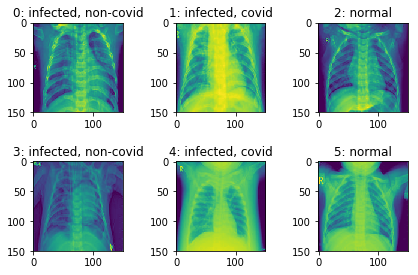

In [5]:
import matplotlib.pyplot as plt

axes = []
def show_tensor_imgs(tensor_imgs, labels):
    '''quick and dirty function to display tensor image'''
    n = len(tensor_imgs)
    fig = plt.figure()
    for i in range(n):
        axes.append(fig.add_subplot(2, 3, i+1)) # add subplot
        subplot_title = (str(i) + ': ' + labels[i])    # name subplot by index
        axes[-1].set_title(subplot_title) 
        plt.imshow(tensor_imgs[i])
    fig.tight_layout()

labels = [
    'infected, non-covid',
    'infected, covid',
    'normal',
    
    'infected, non-covid',
    'infected, covid',
    'normal'
]

imgs = [
    trainset1.open_img('train', 'infected', 1), # infected, non-covid
    trainset2.open_img('train', 'infected', 1), # infected, covid
    trainset2.open_img('train', 'normal', 1),   # normal

    valset1.open_img('val', 'infected', 1), # infected, non-covid
    valset2.open_img('val', 'infected', 1), # infected, covid
    valset2.open_img('val', 'normal', 1)    # normal    
]

show_tensor_imgs(imgs, labels)
plt.show()

# Data Exploration

## Dataset Imbalance

A quick exploration of the dataset shows that there is a clear imbalance:

- 1341 images for the train dataset, normal class,
- 2530 images for the train dataset, infected and non-covid class,
- 1345 images for the train dataset, infected and covid class,
- 234 images for the test dataset, normal class,
- 242 images for the test dataset, infected and non-covid class,
- 138 images for the test dataset, infected and covid class,
- 8 images for the val dataset, normal class,
- 8 images for the val dataset, infected and non-covid class,
- 8 images for the val dataset, infected and covid class.

Plotting the distribtion of cases for `train` dataset and `validation` dataset, we get the following:

Text(0.5, 1.0, 'Dataset Class Distribution')

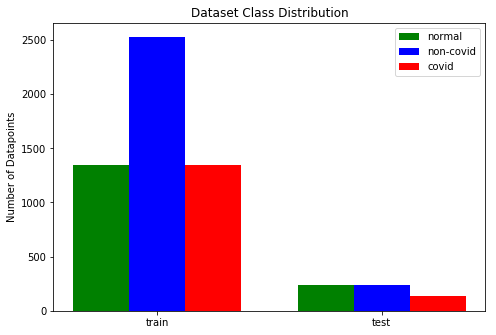

In [6]:
import numpy as np

data = [
    [1341, 234],
    [2530, 242],
    [1345, 138]
]

X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'g', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'b', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

ax.set_xticks(X + 0.25)
ax.set_xticklabels(['train', 'test'])
ax.set_ylabel('Number of Datapoints')
ax.legend(labels=['normal', 'non-covid', 'covid'])
ax.set_title('Dataset Class Distribution')

As can be seen there are twice as many `non-covid` cases as there are `normal` or `covid` cases for the `train` dataset. This is especially problematic for the second classifier that attempts to separate `covid` cases from `non-covid` as `non-covid` cases are the majority (the class that we're not interested in).

Whereas in the case of the first classifier that attempts to seperate `normal` cases from `infected` cases, this will be less of a problem as the `infected` class `(covid + non-covid)` (the class we're interested in) is the overwhelming majority in the `train` dataset. 

Text(0.5, 1.0, 'Dataset Class Distribution for First (Normal) Classifier')

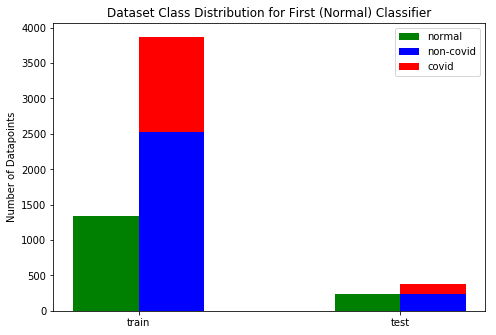

In [13]:
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'g', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[2], color = 'r', width = 0.25, bottom=data[1])

ax.set_xticks(X + 0.125)
ax.set_xticklabels(['train', 'test'])
ax.set_ylabel('Number of Datapoints')
ax.legend(labels=['normal', 'non-covid', 'covid'])
ax.set_title('Dataset Class Distribution for First (Normal) Classifier')

Text(0.5, 1.0, 'Dataset Class Distribution for Second (Covid) Classifier')

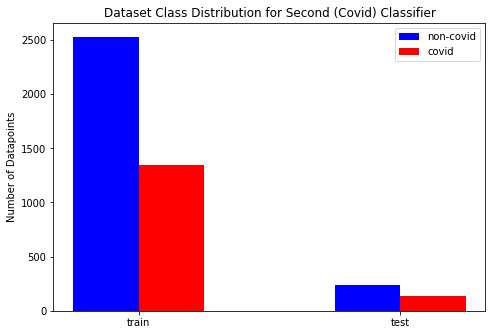

In [15]:
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X, data[1], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[2], color = 'r', width = 0.25)

ax.set_xticks(X + 0.125)
ax.set_xticklabels(['train', 'test'])
ax.set_ylabel('Number of Datapoints')
ax.legend(labels=['non-covid', 'covid'])
ax.set_title('Dataset Class Distribution for Second (Covid) Classifier')

As a result of this **imbalance in the dataset** for both the first and second classifier, the **trained classifier can become 'naive'** because it may end up just guessing the majority class while still leading to decent accuracies on test set. This is especially problematic for the `covid` classifier where `covid` cases (the one we're interested in) are the minority, and less of a prominent problem in the `normal` classifier as the `infected` class (the one we're interested in) is the majority.

To remedy this, we have decided to **optimize for a different metric** called `sensitivity` or `recall` instead of `accuracy`. In healthcare context, where it is far more important to detect the rare minority class, and far more punishing to classify false negative than false positive, metric like `sensitivity` may make more sense than `accuracy`.

There are also other techniques that we have used to remedy this such as **oversampling the minority class** and **adjusting the weights of the components of the cross entropy loss function** (explained later).

## Preprocessing

There are 2 key preprocessing that needs to be done. **Normalization and data augmentation.**

Normalization is important to centralize the values of the pixels to a certain range. This helps to ensure that the gradient values do not become too small or too large to some feature values, which means one common learning rate can then be used to update the weights across the network.

In [17]:
# getting normalization value for classifier 1 & 2
trainset_len = 2530 + 1341 + 1345
train_data = DataLoader(trainsets, batch_size=trainset_len, shuffle=True)
data = next(iter(train_data))
mean = data[0].mean() 
std = data[0].std()

mean, std

(tensor(0.4824), tensor(0.2363))

Another preprocessing that we have done is to add random rotation (max 45 degrees) and random horizontal flip to the image data before it is passed into the network to train.

These data augmentations make sense because the distinguishing feature between `normal` and `infected` cases are the white pneumonia patterns in the x-ray images. **These patterns are rotation and translation invariant.** Furthermore, it also do not matter whether the pneumonia patterns are found on the right or left lung.

Thus, by adding these random transformations during training, we hope to help the model learn these characteristics.

These data augmentations and normalization are done at training time. During test time, only normalization is done on the input image.

# Classifier Architecture:
From researching the topic, our group was initially unable to form a definitive conclusion since most answers seemed to (vaguely) point that the best approach would depend on the nature of the problem, the amount of data available, and computation power.

As recommended by Prof Mari, we decided to build out both architectures with a relatively simple model as an experiment. Even though the multiclass classifier achieved a higher overall accuracy, we then realised that it would be far easier to diagnose and tweak two binary classifiers separately than in a single model, and hence went with the cascaded structure instead.

Our rationale for this choice is that our overall goal would be to build a model with high sensitivity (rather than accuracy) in order to pick out infected cases from the data and ensure that these patients can seek medical treatment - favouring Type 1 over Type 2 errors. Additionally, since Covid-19 is highly contagious, there is an impetus to try detect as many of these from the infected cases as well. Hence, the cascaded binary classifier structure naturally aligns with this by allowing us to finetune for sensitivity at each stage.

Below is a brief summary of what we believe to be the tradeoffs of each model.

## Comparison Summary 
#### Multiclass Pros
- Simple to use since we only have to deal with a single model
- Seemed to be able to obtain higher overall accuracy than the cascaded structure on this particular dataset (85% versus 90%*75%=~70%)

#### Multiclass Cons
- Hard to diagnose, and thus difficult to finetune the relationship between the three classes

#### Cascaded Binary Pros
- Easy to input weights for different classifications in the step-wise process to finetune sensitivity
- Converges faster on a per-model basis
- More accurate in theory due to the potential of modeling pair-wise relationships between classes

#### Cascaded Binary Cons
- Irritating to tweak and evaluate, in addition to needing extra steps to build the dataloaders for each one
- Overall time to train is longer due to the presence of two models


Logically speaking, this may be why doctors in practice do not use x-ray scans to classify the source of lung damage, but only to confirm the presence of it. Hence, this exercise of actually determining what caused the lung damage is a fallacy in itself, and the best way to account for this is to use a separate classifier.

# Choice of CNN Architecture
Rather than conceive a completely new architecture from our limited knowledge, our group adopted an approach where we trained and evaluated a few of the available predefined models in torchvision, then selected the best contender to build from scratch so that we could tweak it.

Given the constraints of 1) a relatively small training dataset and 2) limited computation power, we decided to keep the number of parameters on the lower side to follow the golden rule of machine learning. Hence, from the illustration below plotting top-1 accuracy against the number of operations, we selected the ResNet, DenseNet, MobileNet, and Inception architectures. Specifically, we chose ResNet-18, DenseNet-121, MobileNetV2 and Inception-v3.

<img src="https://miro.medium.com/max/4000/1*n16lj3lSkz2miMc_5cvkrA.jpeg" style="height:300px">

After testing the models, we found that ResNet-18 was the clear winner for our base model, consistently achieving the highest accuracy on the validation set with the lowest loss on the training set, while also taking the shortest time to train. The figures below show the best models achieved within 10 epochs for both binary classifiers #1 and #2.

|                    | ResNet-18 | DenseNet121 | Inception-v3 | MobileNetV2 |
|--------------------|-----------|-------------|--------------|-------------|
| Train Avg. Loss #1 | 0.2689    | 0.2829      | 0.4727       | 0.4377      |
| Val Avg. Loss #1   | 0.0288    | 0.0534      | 0.1573       | 0.1125      |
| Val Accuracy #1    | 92%       | 88%         | 71%          | 83%         |
| Training Time #1   | 6min 32s  | 21min 58s   | 16min 25s    | 8min 49s    |
| Train Avg. Loss #2 | 0.5802    | 0.5992      | 0.7481       | 0.6383      |
| Val Avg. Loss #2   | 0.1159    | 0.1134      | 0.1631       | 0.1508      |
| Val Accuracy #2    | 75%       | 75%         | 56%          | 62%         |
| Training Time #2   | 4min 49s  | 16min       | 12min        | 6min 32s    |


### Observations 
- DenseNet also performed well, but required significantly more time to train than ResNet - more than 3x
- Inception showed subpar performance (due to the removal of the aux channel), but still required significantly more time to train than ResNet.
- MobileNet (our favoured contender) unfortunately obtained similar results to Inception, and somehow also took slightly longer to train
- All the architectures struggled with the second task of separating covid and non-covid cases.

In [4]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

from train import train, validate

resnet = models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = nn.Linear(num_ftrs, 2)
# print(resnet)

densenet = models.densenet121(pretrained=False)
num_ftrs = densenet.classifier.in_features
densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
densenet.classifier = nn.Linear(num_ftrs, 2)
# print(densenet)

inception = models.inception_v3(pretrained=False, aux_logits=False) #disable auxiliary channel to accept 150x150 images
inception.Conv2d_1a_3x3.conv=nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
num_ftrs = inception.fc.in_features
inception.fc = nn.Linear(num_ftrs,2)
# print(inception)

mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.features[0][0]=nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
num_ftrs = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(num_ftrs, 2)
# print(mobilenet)

In [5]:
from train import train_binary_normal_clf, train_binary_covid_clf

train_binary_normal_clf(10, 4, savePath=None, model=resnet, weight=None, quiet=True)
train_binary_covid_clf(10, 4, savePath=None, model=resnet, weight=None, quiet=True)

Train Epoch: 1
Train set: Average loss: 0.5032
Validation set: Average loss: 0.1801, Accuracy: 15/24 (62%)

Found New Minima at epoch 1 loss: 0.18013657381137213

Train Epoch: 2
Train set: Average loss: 0.3512
Validation set: Average loss: 0.1321, Accuracy: 19/24 (79%)

Found New Minima at epoch 2 loss: 0.13212250793973604

Train Epoch: 3
Train set: Average loss: 0.3304
Validation set: Average loss: 0.0604, Accuracy: 22/24 (92%)

Found New Minima at epoch 3 loss: 0.06036650544653336

Train Epoch: 4
Train set: Average loss: 0.2968
Validation set: Average loss: 0.1091, Accuracy: 20/24 (83%)

Train Epoch: 5
Train set: Average loss: 0.3056
Validation set: Average loss: 0.0572, Accuracy: 23/24 (96%)

Found New Minima at epoch 5 loss: 0.05722993488113085

Train Epoch: 6
Train set: Average loss: 0.3002
Validation set: Average loss: 0.0506, Accuracy: 22/24 (92%)

Found New Minima at epoch 6 loss: 0.05057169760887822

Train Epoch: 7
Train set: Average loss: 0.2689
Validation set: Average loss: 

In [6]:
train_binary_normal_clf(10, 4, savePath=None, model=densenet, weight=None, quiet=True)
train_binary_covid_clf(10, 4, savePath=None, model=densenet, weight=None, quiet=True)

Train Epoch: 1
Train set: Average loss: 0.4614
Validation set: Average loss: 0.1324, Accuracy: 16/24 (67%)

Found New Minima at epoch 1 loss: 0.13236750600238642

Train Epoch: 2
Train set: Average loss: 0.3546
Validation set: Average loss: 0.1055, Accuracy: 19/24 (79%)

Found New Minima at epoch 2 loss: 0.10549515672028065

Train Epoch: 3
Train set: Average loss: 0.3266
Validation set: Average loss: 0.1249, Accuracy: 19/24 (79%)

Train Epoch: 4
Train set: Average loss: 0.3046
Validation set: Average loss: 0.0852, Accuracy: 20/24 (83%)

Found New Minima at epoch 4 loss: 0.08515533133565138

Train Epoch: 5
Train set: Average loss: 0.2984
Validation set: Average loss: 0.0933, Accuracy: 20/24 (83%)

Train Epoch: 6
Train set: Average loss: 0.2980
Validation set: Average loss: 0.0687, Accuracy: 21/24 (88%)

Found New Minima at epoch 6 loss: 0.06870392366545275

Train Epoch: 7
Train set: Average loss: 0.2829
Validation set: Average loss: 0.0534, Accuracy: 21/24 (88%)

Found New Minima at epoc

In [7]:
train_binary_normal_clf(10, 4, savePath=None, model=inception, weight=None, quiet=True)
train_binary_covid_clf(10, 4, savePath=None, model=inception, weight=None, quiet=True)

Train Epoch: 1
Train set: Average loss: 0.5331
Validation set: Average loss: 0.1753, Accuracy: 14/24 (58%)

Found New Minima at epoch 1 loss: 0.17527922677497068

Train Epoch: 2
Train set: Average loss: 0.4877
Validation set: Average loss: 0.1918, Accuracy: 16/24 (67%)

Train Epoch: 3
Train set: Average loss: 0.5236
Validation set: Average loss: 0.2788, Accuracy: 14/24 (58%)

Train Epoch: 4
Train set: Average loss: 0.5581
Validation set: Average loss: 0.2099, Accuracy: 16/24 (67%)

Train Epoch: 5
Train set: Average loss: 0.5609
Validation set: Average loss: 0.2309, Accuracy: 16/24 (67%)

Train Epoch: 6
Train set: Average loss: 0.5106
Validation set: Average loss: 0.2347, Accuracy: 15/24 (62%)

Train Epoch: 7
Train set: Average loss: 0.4727
Validation set: Average loss: 0.1573, Accuracy: 17/24 (71%)

Found New Minima at epoch 7 loss: 0.15726305293113305

Train Epoch: 8
Train set: Average loss: 0.4305
Validation set: Average loss: 0.2191, Accuracy: 16/24 (67%)

Train Epoch: 9
Train set: 

In [8]:
train_binary_normal_clf(10, 4, savePath=None, model=mobilenet, weight=None, quiet=True)
train_binary_covid_clf(10, 4, savePath=None, model=mobilenet, weight=None, quiet=True)

Train Epoch: 1
Train set: Average loss: 0.5432
Validation set: Average loss: 0.1180, Accuracy: 16/24 (67%)

Found New Minima at epoch 1 loss: 0.11798713852961858

Train Epoch: 2
Train set: Average loss: 0.4377
Validation set: Average loss: 0.1125, Accuracy: 20/24 (83%)

Found New Minima at epoch 2 loss: 0.11252926041682561

Train Epoch: 3
Train set: Average loss: 0.4176
Validation set: Average loss: 0.1160, Accuracy: 17/24 (71%)

Train Epoch: 4
Train set: Average loss: 0.4309
Validation set: Average loss: 0.1445, Accuracy: 18/24 (75%)

Train Epoch: 5
Train set: Average loss: 0.4226
Validation set: Average loss: 0.1505, Accuracy: 17/24 (71%)

Train Epoch: 6
Train set: Average loss: 0.4203
Validation set: Average loss: 0.1665, Accuracy: 18/24 (75%)

Train Epoch: 7
Train set: Average loss: 0.4395
Validation set: Average loss: 0.1420, Accuracy: 18/24 (75%)

Train Epoch: 8
Train set: Average loss: 0.4257
Validation set: Average loss: 0.1222, Accuracy: 17/24 (71%)

Train Epoch: 9
Train set: 

# Final Modified ResNet:
The final model we used is a modified version of ResNet-18 as it is the highest performing of all that we tested. Additionally, we did not go with deeper layered resnet as it started to show overfitting after longer training, and we believed ResNet-18 has the sufficient layers to allow the model to generalise better.

We also experimented with adding dropout layers and sees a slight increase in performance.

In [2]:
from model import ResNet
model=ResNet()
print(model)

ResNet(
  (layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2)

## Loss Function and Weight Adjustment
We used the Cross Entropy Loss criterion implemented in pytorch for convenience, which combines LogSoftmax and NLLLoss in one single class.

In order to finetune the model to optimize for `sensitivity` of our model at each stage, we input a weight tensor which would **penalise false negative more** (misclassifying `infected` and `covid` as `normal` and `non-covid` for stage 1 and 2 respectively). While perhaps slightly 'hacky', it was successful in increasing the sensitivity. Through some trial and error, we arrived at weights `[1.0, 1.1]` for first classifier (`normal classifier`) and `[1.0, 1.15]` for second classifier (`covid classifier`) which maximised sensitivity without sacrificing too much accuracy.

Note that, the original model without weight adjustment has performed fairly well in terms of `sensitivity` probably thanks to oversampling and the architecture. However, to further optimize for `sensitivity` we find that adjusting the weights in the loss function works best even though it comes at the cost of some `accuracy`.

In [1]:
!python train.py

Train Epoch: 1
Train Epoch: 1 [0/6557 (0%)]	Loss: 10.913421
Train Epoch: 1 [400/6557 (6%)]	Loss: 10.566383
Train Epoch: 1 [800/6557 (12%)]	Loss: 9.716506
Train Epoch: 1 [1200/6557 (18%)]	Loss: 7.353319
Train Epoch: 1 [1600/6557 (24%)]	Loss: 5.709531
Train Epoch: 1 [2000/6557 (30%)]	Loss: 6.725890
Train Epoch: 1 [2400/6557 (37%)]	Loss: 5.508781
Train Epoch: 1 [2800/6557 (43%)]	Loss: 5.377548
Train Epoch: 1 [3200/6557 (49%)]	Loss: 2.343995
Train Epoch: 1 [3600/6557 (55%)]	Loss: 11.576360
Train Epoch: 1 [4000/6557 (61%)]	Loss: 5.545029
Train Epoch: 1 [4400/6557 (67%)]	Loss: 8.961969
Train Epoch: 1 [4800/6557 (73%)]	Loss: 2.716870
Train Epoch: 1 [5200/6557 (79%)]	Loss: 12.883558
Train Epoch: 1 [5600/6557 (85%)]	Loss: 1.533314
Train Epoch: 1 [6000/6557 (91%)]	Loss: 14.366716
Train Epoch: 1 [6400/6557 (98%)]	Loss: 2.992687
Train set: Average loss: 0.7491
Validation set: Average loss: 0.0703, Accuracy: 22/32 (69%)

Found New Minima at epoch 1 loss: 0.07026839628815651

Train Epoch: 2
Train Ep

# Results

The results will be delivered by specifying args to the test file. For brevity, we will compare results in the following manner:

1. Independent Binary Accuracy
2. Independent Binary Sensitivity
3. Independent Binary Confusion Matrix
4. Piped Binary Accuracy
5. Piped Binary Sensitivity
6. Comparison of Validation Images

2 classifiers will be used throughout. One of it is referred to as the `normal classifier`, which outputs 0 for `normal`, 1 for `infected` (both covid and non-covid). The other one is referred to as the `covid classifier`, which outputs 0 for `non-covid`, 1 for `covid`. Since we are interested in seeing how accurate and sensitive they can get, we have 2 different set of models for both of these metrics. The model being used will be stated clearly in the following sections.

## Independent Metrics

For the following metrics, both binary classifiers are treated as independent as we are interested in them individually. The following notations are used:

- `TP`: True Positive
- `FP`: False Positive
- `TN`: True Negative
- `FN`: False Negative

**TAKE NOTE** The **first** set of returned result will treat **normal as negative, infected as positive**. The **second** set of returned result will treat **non-covid as negative, covid as positive**


### 1. Independent Binary Accuracy

We are interested in their individual accuracy in terms of predicting labels that are the same as the ground truth. The metric that we will be focusing on will be **"Testing Accuracy"**. This is obtained by taking (TP + TN) / len(testloader). Both the accuracy model and the sensitivity model will be tested.


### 2. Independent Binary Sensitivity

The metric that we will be focusing on will be the **"Testing Sensitivity"**. This metric reflects how well the model is prioritising misclassifying cases as infected/covid ones as a preventive measure. This is obtained by taking safe_division(TP, (TP+FN)). The safe_division method returns 0 if there is division by zero from TP+FN, otherwise returns the regular division. Both the accuracy model and the sensitivity model will be tested.


### 3. Independent Binary Confustion Matrix

This metric puts together the confusion matrix for both classifiers. We will be looking at **Confusion Matrix**. Both the accuracy model and the sensitivity model will be tested

In [2]:
# best accuracy model
!python test.py --independent 1 --validation 0 --print 1 --output_var 2 --normalclf binaryModelNormalBest --covidclf binaryModelCovidBest

Starting: Test set on Normal Independent classifier
Total=614, TP=369, FP=79, FN=11, TN=155
Testing Accuracy: 0.853
Testing Sensitivity: 0.971
Testing Specificity: 0.662
Testing PPV: 0.824
Testing NPV: 0.934
Testing F1 Score: 0.891
Confusion Matrix
          Predicted N | Predicted P
         ---------------------------
Ground N |   TN = 155  |   FP = 79   |
Ground P |   FN = 11  |   TP = 369   |


Starting Test set on Covid Independent classifier
Total=380, TP=126, FP=36, FN=12, TN=206
Testing Accuracy: 0.874
Testing Sensitivity: 0.913
Testing Specificity: 0.851
Testing PPV: 0.778
Testing NPV: 0.945
Testing F1 Score: 0.840
Confusion Matrix
          Predicted N | Predicted P
         ---------------------------
Ground N |   TN = 206  |   FP = 36   |
Ground P |   FN = 12  |   TP = 126   |




In [3]:
# best sensitivity model
!python test.py --independent 1 --validation 0 --print 1 --output_var 2 --normalclf binaryModelNormalBestSensitivity --covidclf binaryModelCovidBestSensitivity

Starting: Test set on Normal Independent classifier
Total=614, TP=377, FP=116, FN=3, TN=118
Testing Accuracy: 0.806
Testing Sensitivity: 0.992
Testing Specificity: 0.504
Testing PPV: 0.765
Testing NPV: 0.975
Testing F1 Score: 0.864
Confusion Matrix
          Predicted N | Predicted P
         ---------------------------
Ground N |   TN = 118  |   FP = 116   |
Ground P |   FN = 3  |   TP = 377   |


Starting Test set on Covid Independent classifier
Total=380, TP=129, FP=61, FN=9, TN=181
Testing Accuracy: 0.816
Testing Sensitivity: 0.935
Testing Specificity: 0.748
Testing PPV: 0.679
Testing NPV: 0.953
Testing F1 Score: 0.787
Confusion Matrix
          Predicted N | Predicted P
         ---------------------------
Ground N |   TN = 181  |   FP = 61   |
Ground P |   FN = 9  |   TP = 129   |




**As can be seen, the `binaryModelNormalBest` and `binaryModelCovidBest` model scores better in terms of `accuracy` at the cost of some amount of false negatives.**

**Whereas if we were to optimize for `sensitivity` by penalizing FN through weight adjustment in the Cross Entropy Loss function, we can improve the `sensitivity` at the cost of `accuracy` as shown in the `binaryModelNormalBestSensitivity` and `binaryModelCovidBestSensitivity` model.**

## Piped Binary Metrics

As we ultimately chose to use a piped double binary model for this project (second diagram in the given project handout), the printed metric values may look different from its independently considered counterparts in the above section. Once again, TP FP TN FN will be used. 

**TAKE NOTE** The **first** set of returned result will treated **normal as negative, infected as positive**. The **second** set of returned result will treat **non-covid/normal as negative, covid as positive**


### 4. Piped Binary Accuracy

The metric that we will be focusing on will be **"Testing Accuracy"**. This is obtained by taking (TP + TN) / len(testloader). Both the accuracy model and the sensitivity model will be tested.


### 5. Piped Binary Sensitivity

The metric that we will be focusing on will be **"Testing Sensitivity"**. This metric reflects how well the model is prioritising misclassifying cases as infected/covid ones as a preventive measure. This is obtained by taking safe_division(TP, (TP+FN)). The safe_division method returns 0 if there is division by zero from TP+FN, otherwise returns the regular division. Both the accuracy model and the sensitivity model will be tested.

In [4]:
# best accuracy
!python test.py --independent 0 --validation 0 --print 1 --output_var 2 --normalclf binaryModelNormalBest --covidclf binaryModelCovidBest

Starting: Test set on Normal Piped classifier
Total=614, TP=369, FP=79, FN=11, TN=155
Testing Accuracy: 0.853
Testing Sensitivity: 0.971
Testing Specificity: 0.662
Testing PPV: 0.824
Testing NPV: 0.934
Testing F1 Score: 0.891
Confusion Matrix
          Predicted N | Predicted P
         ---------------------------
Ground N |   TN = 155  |   FP = 79   |
Ground P |   FN = 11  |   TP = 369   |


Starting: Test set on Covid Piped classifier
Total=448, TP=129, FP=308, FN=2, TN=9
Testing Accuracy: 0.308
Testing Sensitivity: 0.985
Testing Specificity: 0.028
Testing PPV: 0.295
Testing NPV: 0.818
Testing F1 Score: 0.454
Confusion Matrix
          Predicted N | Predicted P
         ---------------------------
Ground N |   TN = 9  |   FP = 308   |
Ground P |   FN = 2  |   TP = 129   |




In [5]:
# best sensitivity
!python test.py --independent 0 --validation 0 --print 1 --output_var 2 --normalclf binaryModelNormalBestSensitivity --covidclf binaryModelCovidBestSensitivity

Starting: Test set on Normal Piped classifier
Total=614, TP=377, FP=116, FN=3, TN=118
Testing Accuracy: 0.806
Testing Sensitivity: 0.992
Testing Specificity: 0.504
Testing PPV: 0.765
Testing NPV: 0.975
Testing F1 Score: 0.864
Confusion Matrix
          Predicted N | Predicted P
         ---------------------------
Ground N |   TN = 118  |   FP = 116   |
Ground P |   FN = 3  |   TP = 377   |


Starting: Test set on Covid Piped classifier
Total=493, TP=138, FP=355, FN=0, TN=0
Testing Accuracy: 0.280
Testing Sensitivity: 1.000
Testing Specificity: 0.000
Testing PPV: 0.280
Testing NPV: 0.000
Testing F1 Score: 0.437
Confusion Matrix
          Predicted N | Predicted P
         ---------------------------
Ground N |   TN = 0  |   FP = 355   |
Ground P |   FN = 0  |   TP = 138   |




We believe that this piped metric are **NOT as indicative** of the classifiers whole performance especially for the second classifier. For example, in the case of `binaryModelNormalBestSensitivity`, it will pass in too many False Positives into the second covid classifier, as these are supposed to be classified as `normal`, the second classifier will have no choice but to be penalized because it only has the option to classify it as either `covid` or `non-covid`, both of which are wrong.

Thus, we recommend looking at the **independent** metrics to evaluate the performance.

### 6. Comparison of Validation Images

#### 6.1 On Best Accuracy Model

The following shows the plots of the best accuracy model on the validation plot. The first one shows the indepenent classifiers, while the second shows the piped classifiers.

Starting: Validation set on Normal Independent classifier
Starting: Validation set on Covid Independent classifier
displaying normal validation independent results in the format of (target) -> (predicted)
displaying covid validation independent results in the format of (target) -> (predicted)


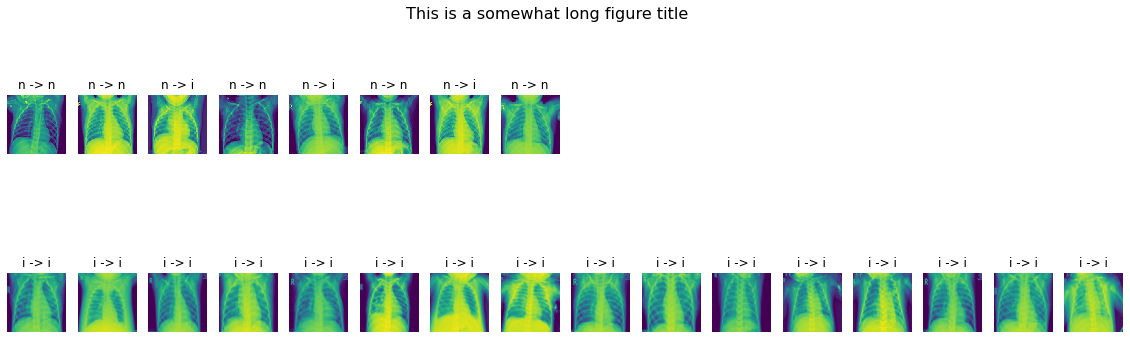

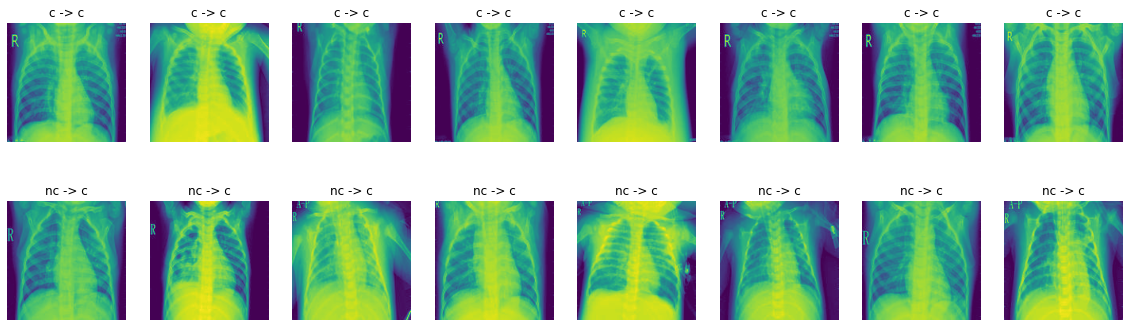

In [10]:
# independent best accuracy
%run test.py --independent 1 --validation 1 --print 0 --output_var 2 --normalclf binaryModelNormalBest --covidclf binaryModelCovidBest

Starting: Validation set on Normal Piped classifier
Total=24, TP=16, FP=3, FN=0, TN=5
Testing Accuracy: 0.875
Testing Sensitivity: 1.000
Testing Specificity: 0.625
Testing PPV: 0.842
Testing NPV: 1.000
Testing F1 Score: 0.914
Confusion Matrix
          Predicted N | Predicted P
         ---------------------------
Ground N |   TN = 5  |   FP = 3   |
Ground P |   FN = 0  |   TP = 16   |


Starting: Validation set on Covid Piped classifier
Total=19, TP=8, FP=11, FN=0, TN=0
Testing Accuracy: 0.421
Testing Sensitivity: 1.000
Testing Specificity: 0.000
Testing PPV: 0.421
Testing NPV: 0.000
Testing F1 Score: 0.593
Confusion Matrix
          Predicted N | Predicted P
         ---------------------------
Ground N |   TN = 0  |   FP = 11   |
Ground P |   FN = 0  |   TP = 8   |


displaying validation piped results in the format of (target) -> (predicted)


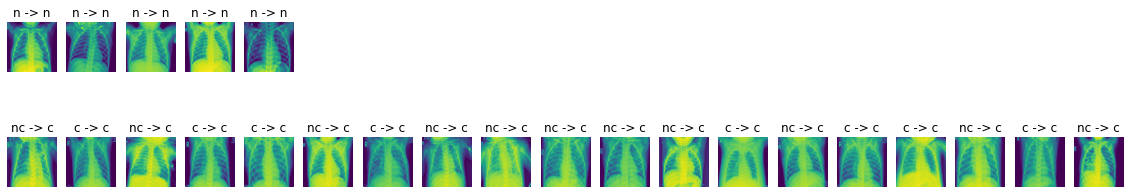

In [5]:
# piped best accuracy
%run test.py --independent 0 --validation 1 --print 0 --output_var 2 --normalclf binaryModelNormalBest --covidclf binaryModelCovidBest

#### 6.2 On Best Sensitivity Model

The following shows the plots of the best accuracy model on the validation plot. The first one shows the indepenent classifiers, while the second shows the piped classifiers.

Starting: Validation set on Normal Independent classifier
Starting: Validation set on Covid Independent classifier
displaying normal validation independent results in the format of (target) -> (predicted)
displaying covid validation independent results in the format of (target) -> (predicted)


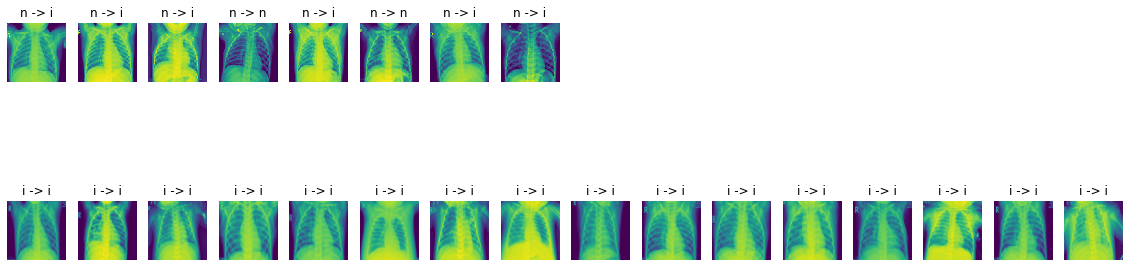

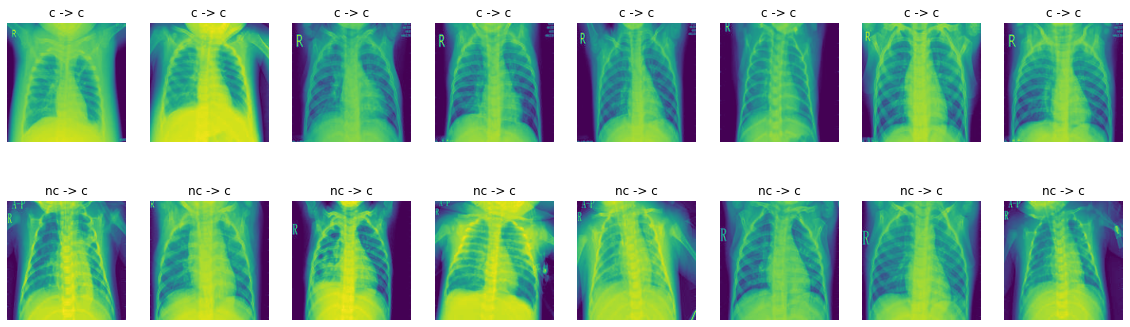

<Figure size 432x288 with 0 Axes>

In [22]:
# independent best sensitivity
%run test.py --independent 1 --validation 1 --print 0 --output_var 2 --normalclf binaryModelNormalBestSensitivity --covidclf binaryModelCovidBestSensitivity

Starting: Validation set on Normal Piped classifier
Starting: Validation set on Covid Piped classifier
displaying validation piped results in the format of (target) -> (predicted)


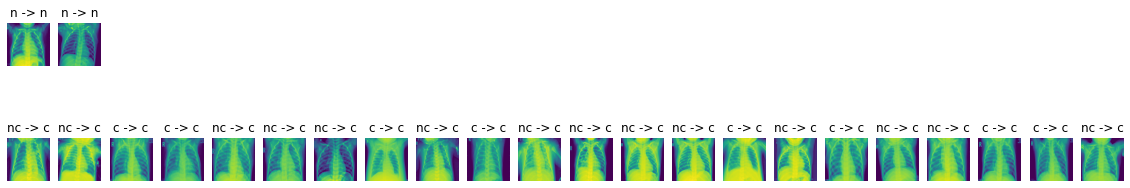

<Figure size 432x288 with 0 Axes>

In [23]:
# piped best sensitivity
%run test.py --independent 0 --validation 1 --print 0 --output_var 2 --normalclf binaryModelNormalBestSensitivity --covidclf binaryModelCovidBestSensitivity

## Final Question

Q: Would it be better to have a model with high overall accuracy or low true negatives/false positives rates on certain classes. Discuss.

A: While generally the rule of thumb is to try and aim to have the model report high accuracy, in this case where real life stakes are high since COVID19 has a high infection rate, it is more preferable to do the latter to reduce the risks of outbreaks from one false positive case. This would mean that more samples may be falsely classified as infected/covid. Although more preventive, in the real world this may instead pose a challenge to the capacities of the healthcare sector. Rather than starting from high accuracy and trying to make the model more sensitive in identifying infected/covid cases, it is easier to push the model towards higher accuracy after having been tuned to have high sensitivity, which is the approach that we have taken.